# I. Problem statement

Dataset: https://archive.ics.uci.edu/ml/datasets/Adult

Prediction task is to determine whether a person makes over 50K a year.

* Class probabilities for adult.all file
* Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
* Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

Description of fnlwgt (final weight)

The weights on the CPS files are controlled to independent estimates of the
civilian noninstitutional population of the US.  These are prepared monthly
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.
  These are:
          1.  A single cell estimate of the population 16+ for each state.
          2.  Controls for Hispanic Origin by age and sex.
          3.  Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through
them 6 times so that by the end we come back to all the controls we used.

The term estimate refers to population totals derived from CPS by creating
"weighted tallies" of any specified socio-economic characteristics of the
population.

People with similar demographic characteristics should have
similar weights.  There is one important caveat to remember
about this statement.  That is that since the CPS sample is
actually a collection of 51 state samples, each with its own
probability of selection, the statement only applies within
state.



# II. Variables

* age: continuous.

* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.

* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

* education-num: continuous.

* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

* sex: Female, Male.

* capital-gain: continuous.

* capital-loss: continuous.

* hours-per-week: continuous.

* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

# III. Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.simplefilter('ignore')


colNames = ['Age', 'WorkClass', 'FnlWgt', 'Education', 'Education-Num', 'Marital-Status', 'Occupation', 
            'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-Loss', 'Hours-Per-Week', 'Native-Country', 'Salary']
dataset = pd.read_csv('data/adult-train.csv', header=None, names = colNames)

# IV. Data preprocessing

## a) Charts

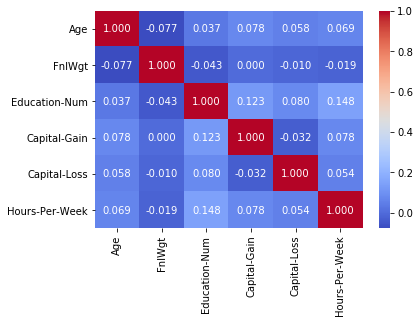

In [2]:
import seaborn as sns

cor_mat = dataset.corr()
sns.heatmap(cor_mat, annot=True, fmt='.3f', cmap='coolwarm')

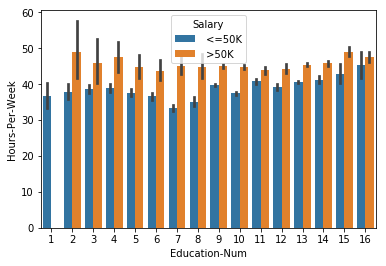

In [3]:
sns.barplot(x='Education-Num', y='Hours-Per-Week', hue='Salary', data=dataset)

Only 'Preschool' education has income <= 50k

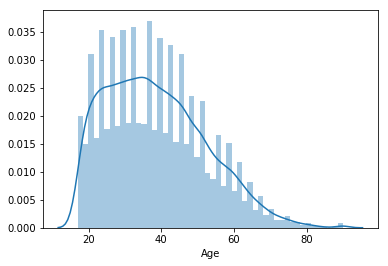

In [4]:
sns.distplot(dataset['Age'].dropna(), kde=True)

Almost of data sample has age from 25 to 50.

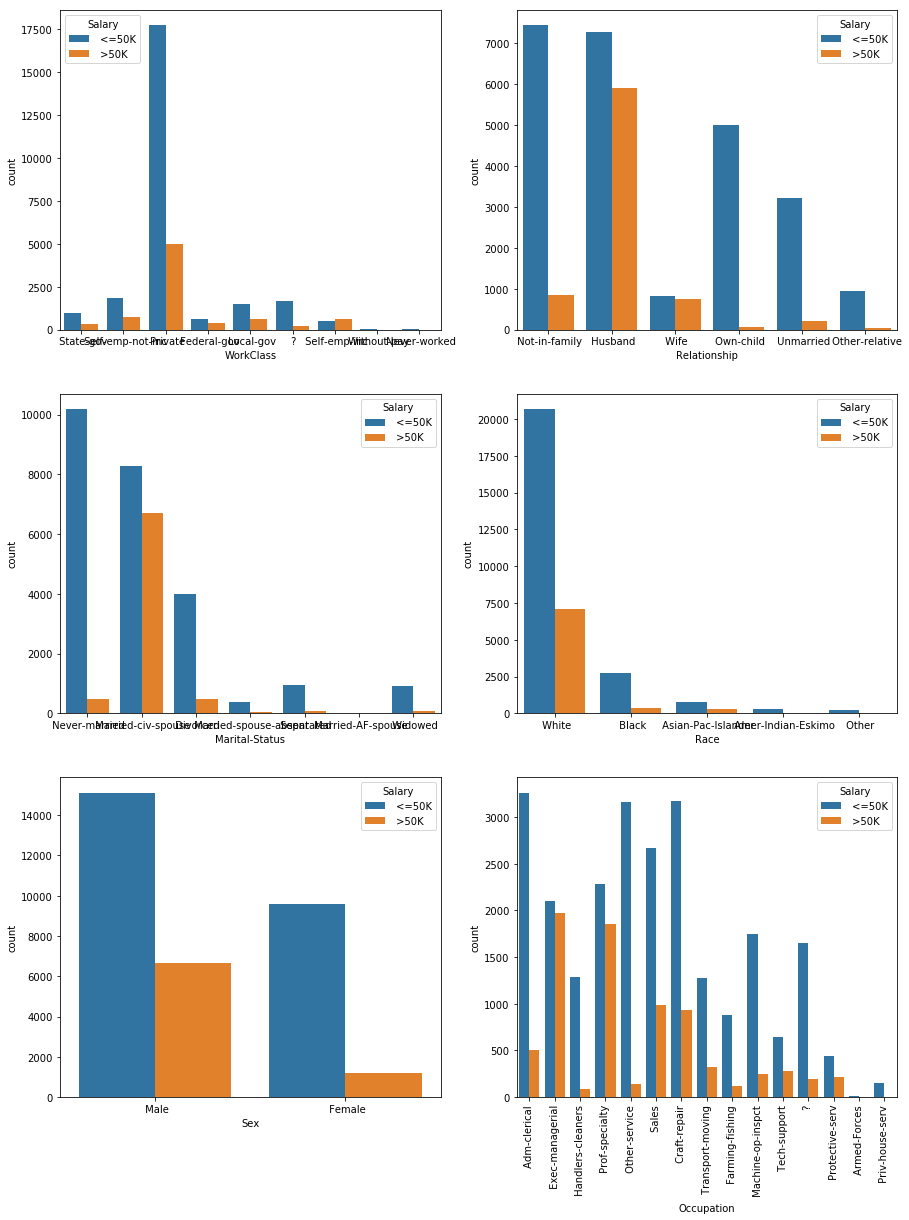

In [5]:
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2,figsize=(15,20))

sns.countplot(x='WorkClass', hue='Salary',data = dataset, ax=a)
sns.countplot(x='Relationship', hue='Salary', data = dataset, ax=b)
sns.countplot(x='Marital-Status', hue='Salary', data = dataset, ax=c)
sns.countplot(x='Race', hue='Salary', data = dataset, ax=d)
sns.countplot(x='Sex', hue='Salary', data = dataset, ax=e)
sns.countplot(x='Occupation', hue='Salary', data = dataset, ax=f)
plt.xticks(rotation=90)
plt.show()

- Work class private has highest income
- Male also has higher income than female
- Exec-managerial and Prof-specialty have highest income

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

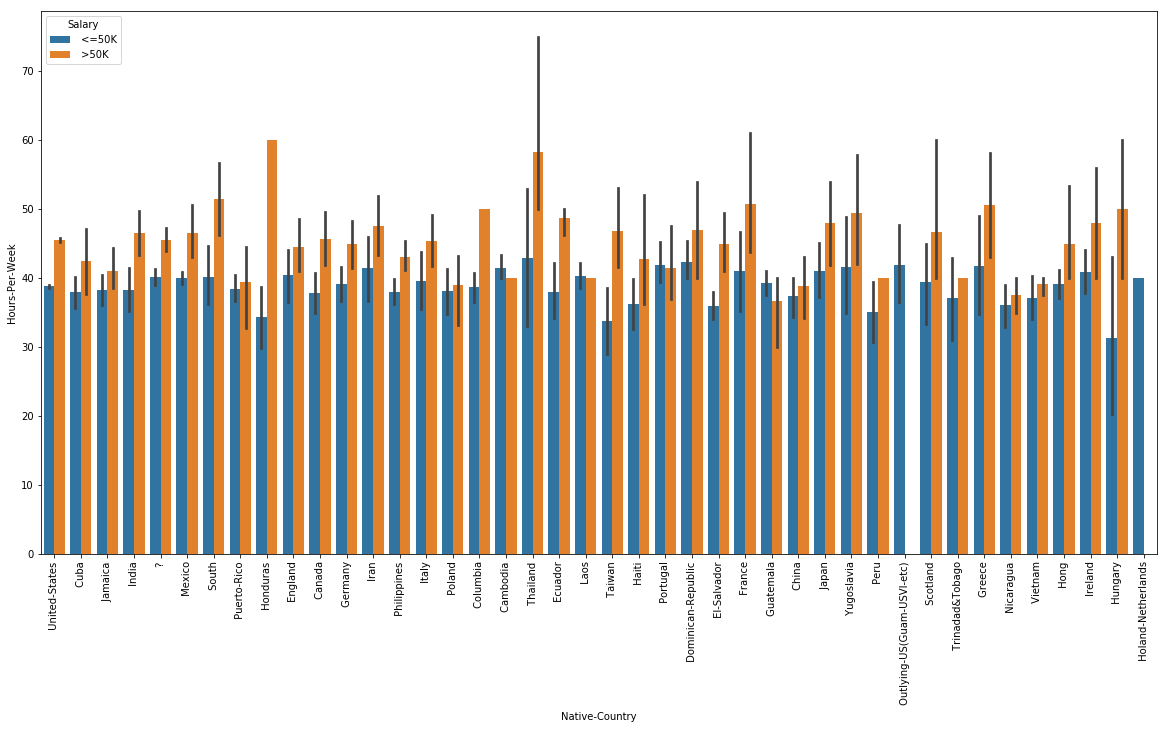

In [6]:
f,ax = plt.subplots(figsize=(20,10))
sns.barplot(x='Native-Country', y='Hours-Per-Week', hue='Salary', data=dataset)
plt.xticks(rotation=90)

- Almost of data sample have high hour working.
- The higher hour working, the higher income.

## b) Data Wrangling

* We tranform the 'Salary' attribute to the categorial values 'Yes' if people salary is greater than 50 K, 'No' if otherwise.

* Remove the redundant column 'Education' which is covered by the column 'Education-Num'

* Remove unknown data from both train and test data

* Normalize data

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Check code https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish#Some-Final-Encoding to encode the 
# category values to numerical values


labelEncoder = LabelEncoder()    
dataset = dataset.apply(labelEncoder.fit_transform)

dropColumns = ['Salary', 'Education']
X = dataset.drop(dropColumns, axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
Y = dataset['Salary']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

# V. Algorithms

## Common method

Define the common methods for later usages such as calculate learning curve, validation curve, draw the graph, etc.

In [8]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def bestParamsClassifier(classifier, params):
    # Type of scoring used to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)
    # Run the grid search
    grid_obj = GridSearchCV(classifier, parameters, scoring=acc_scorer)
    grid_obj.fit(X_train, Y_train)

    # Set the clf to the best combination of parameters
    classifier = grid_obj.best_estimator_
    return classifier

from sklearn.model_selection import learning_curve

def callLearningCurve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring='accuracy',
                                                           train_sizes=np.linspace(0.01, 0.5, 20), cv=None)
    return train_sizes, train_scores, test_scores

def plotLearningCurve(title, train_sizes, train_scores, test_scores):
    # Calculate mean and standard deviation for training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Calculate mean and standard deviation for test set scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    f,ax = plt.subplots(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    
    # Plot mean accuracy scores for training and test sets
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    # Plot accurancy bands for training and test sets
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    

    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve

def callValidationCurve(estimator, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, scoring='accuracy')
    return train_scores, test_scores

def plotValidationCurve(param_range, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    f,ax = plt.subplots(figsize=(20,10))
    plt.title("Validation Curve")
    plt.xlabel("Model Complexity")
    plt.ylabel("Score")

    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="r", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g", lw=lw)
    plt.legend(loc="best")
    plt.show() 

## a) Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

lg_classifier = LogisticRegression()
lg_classifier.fit(X_train, Y_train)
Y_lg_pred = lg_classifier.predict(X_test)
Y_lg_pred_proba = lg_classifier.predict_proba(X_test)
print(accuracy_score(Y_test, Y_lg_pred))
print(classification_report(Y_test, Y_lg_pred))


0.8222594453750233
             precision    recall  f1-score   support

          0       0.84      0.94      0.89      8138
          1       0.71      0.45      0.55      2608

avg / total       0.81      0.82      0.81     10746



### Validation Curve

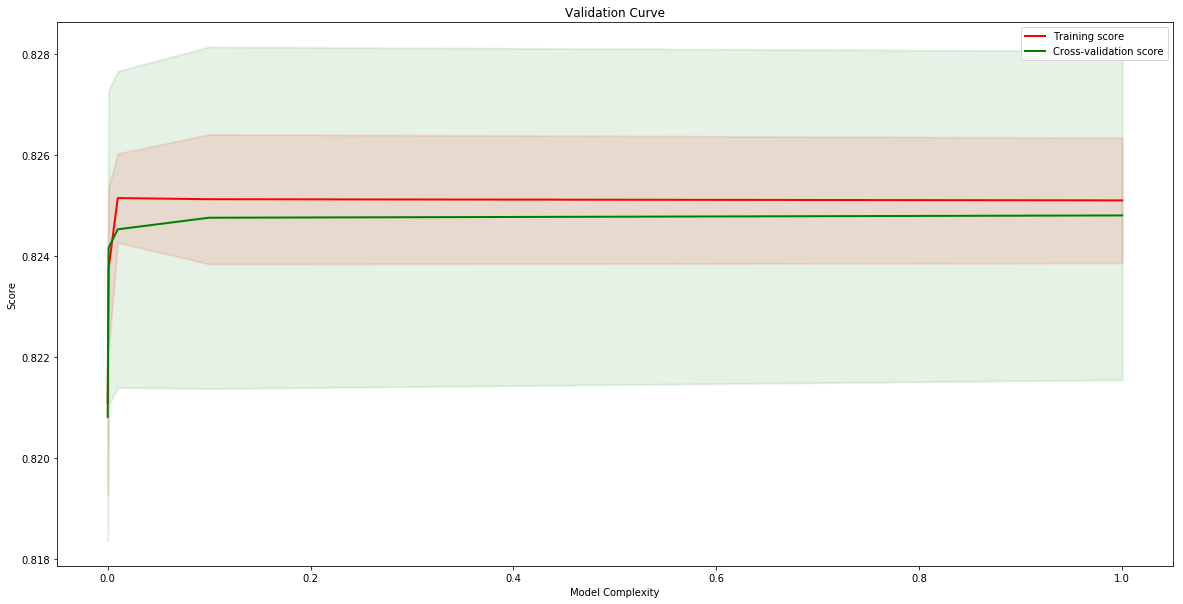

In [10]:
param_range = [0.0001, 0.001,0.01,0.1,1]
train_scores, test_scores = callValidationCurve(LogisticRegression(), X_train, Y_train, param_name='C', 
                                               param_range=param_range)
plotValidationCurve(param_range, train_scores, test_scores)

### Learning Curve

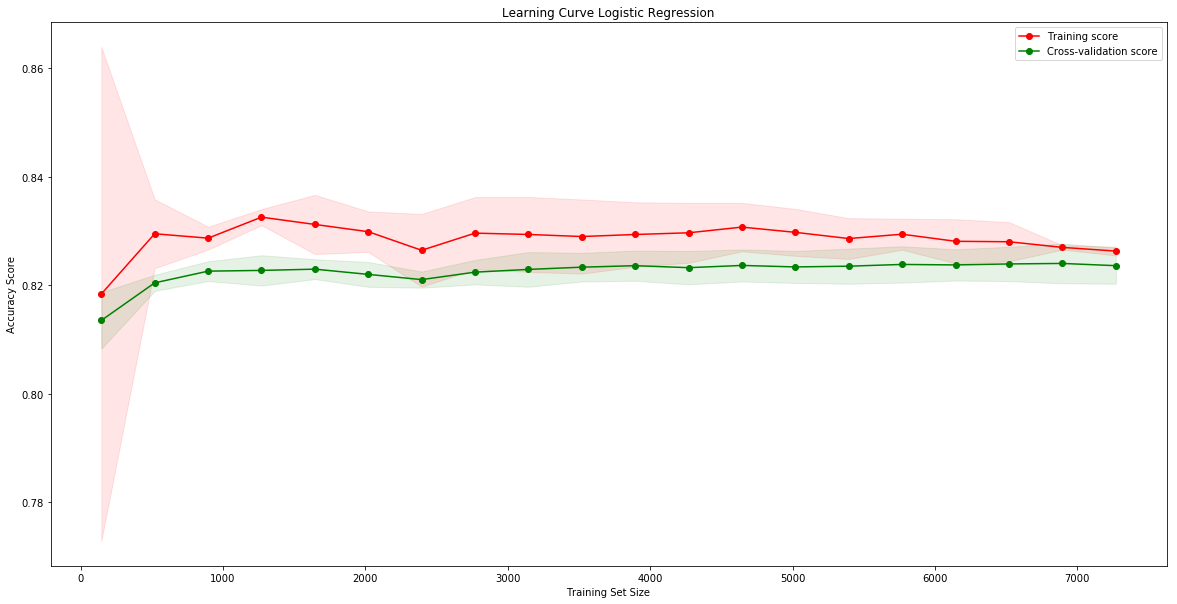

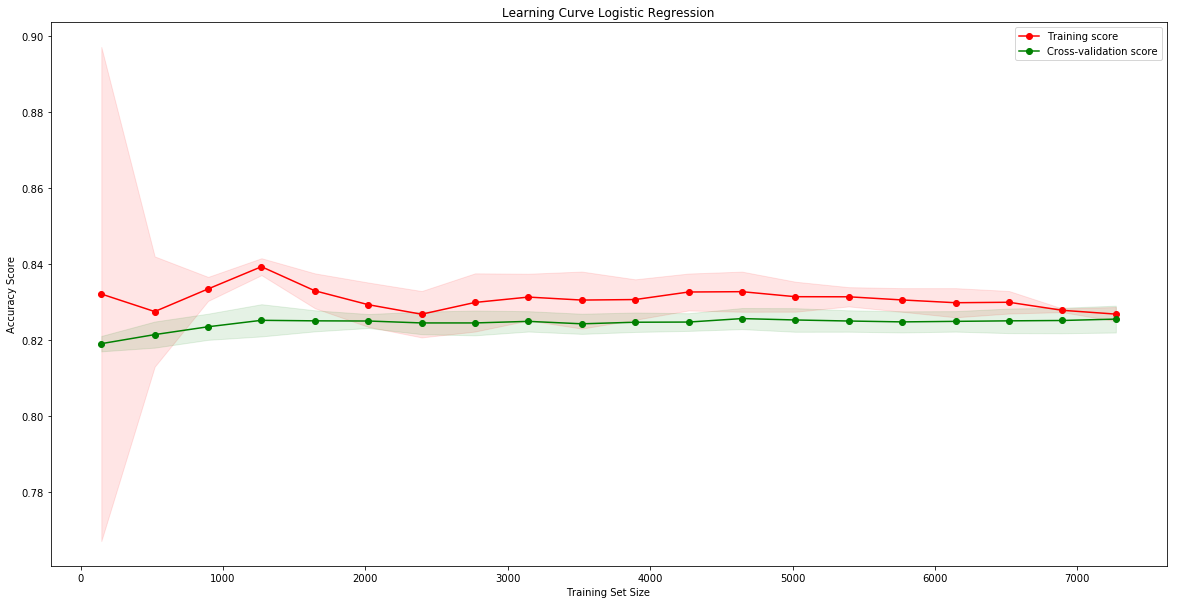

In [11]:
train_sizes, train_scores, test_scores = callLearningCurve(LogisticRegression(C=0.001), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(LogisticRegression(C=1), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

## b)  KNN


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# validation_curve(KNeighborsClassifier(), X_train, Y_train, cv = 3)
# Reference: https://www.dataquest.io/blog/learning-curves-machine-learning/
#train_sizes, train_scores, validation_scores = learning_curve(KNeighborsClassifier(), X_train, Y_train, , cv = 3)

neighbors = [3, 5, 7]
?KNeighborsClassifier
for n_neighbors in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights = 'distance')
    knn_classifier.fit(X_train, Y_train)
    Y_knn_pred = knn_classifier.predict(X_test)
    Y_knn_pred_proba = knn_classifier.predict_proba(X_test)
    print("KNN with neighbors ", n_neighbors)
    print(accuracy_score(Y_test, Y_knn_pred))
    print(classification_report(Y_test, Y_knn_pred))
    


KNN with neighbors  3
0.8297971338172343
             precision    recall  f1-score   support

          0       0.88      0.90      0.89      8138
          1       0.66      0.61      0.64      2608

avg / total       0.83      0.83      0.83     10746

KNN with neighbors  5
0.837427880141448
             precision    recall  f1-score   support

          0       0.88      0.91      0.89      8138
          1       0.68      0.62      0.65      2608

avg / total       0.83      0.84      0.83     10746

KNN with neighbors  7
0.8416154848315652
             precision    recall  f1-score   support

          0       0.88      0.91      0.90      8138
          1       0.69      0.62      0.66      2608

avg / total       0.84      0.84      0.84     10746



The best hyperparameter is n_neighbors = 7

### Validation Curve

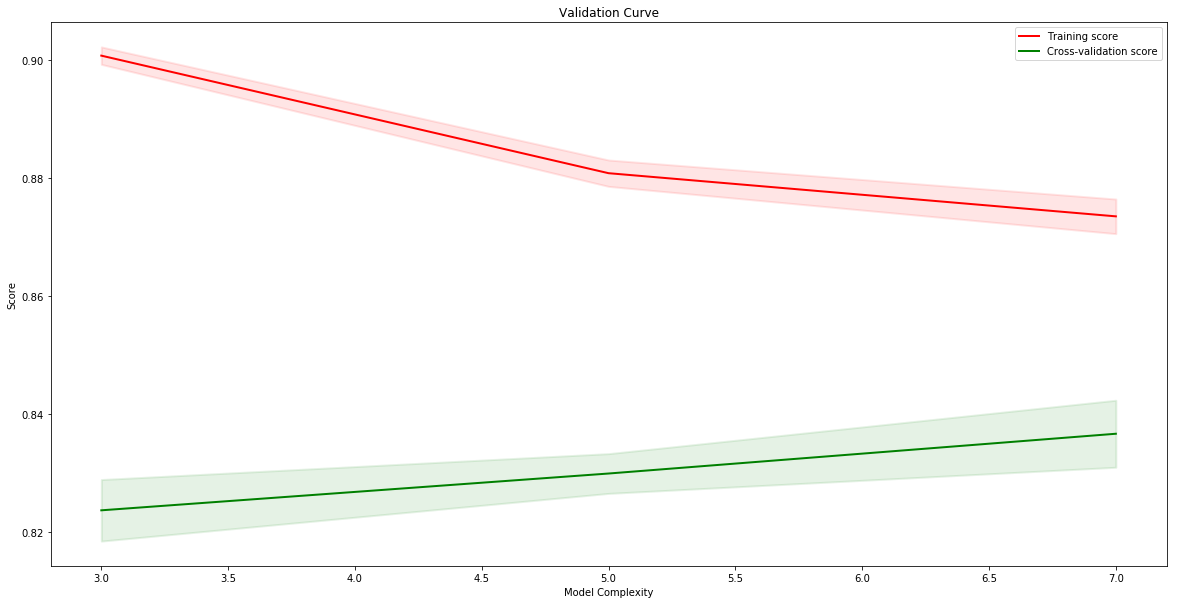

In [13]:
train_scores, test_scores = callValidationCurve(KNeighborsClassifier(), 
                                                X_train, Y_train, "n_neighbors", neighbors)
plotValidationCurve(neighbors, train_scores, test_scores)

The validation score increase over the neighbors, and the variance reduces over this hyper-parameter (neighbors)

### Learning Curve

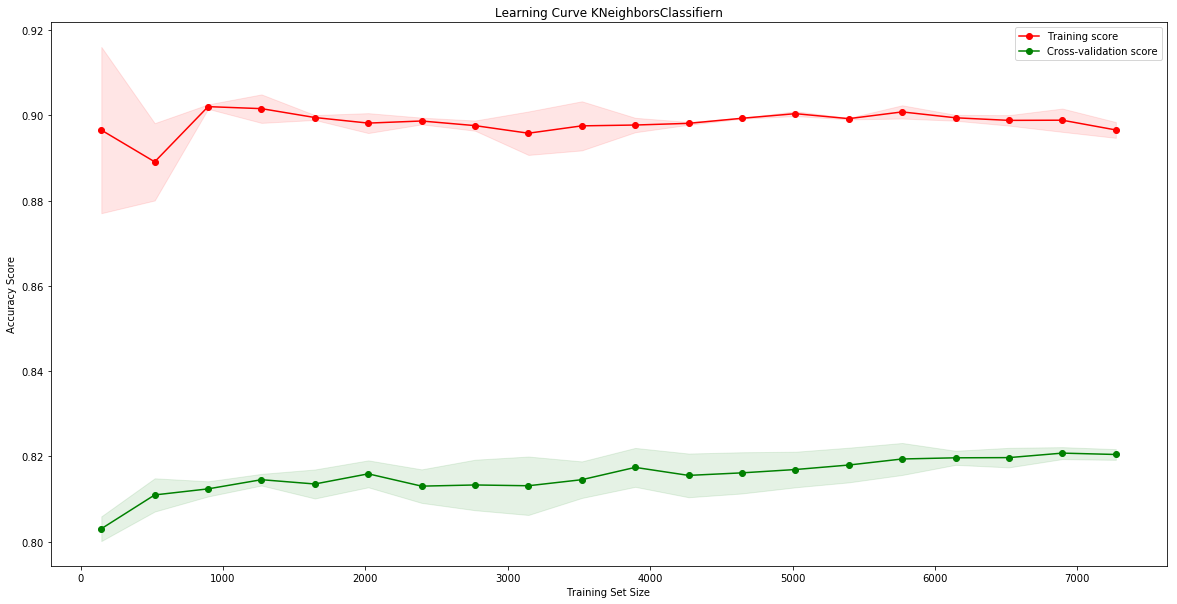

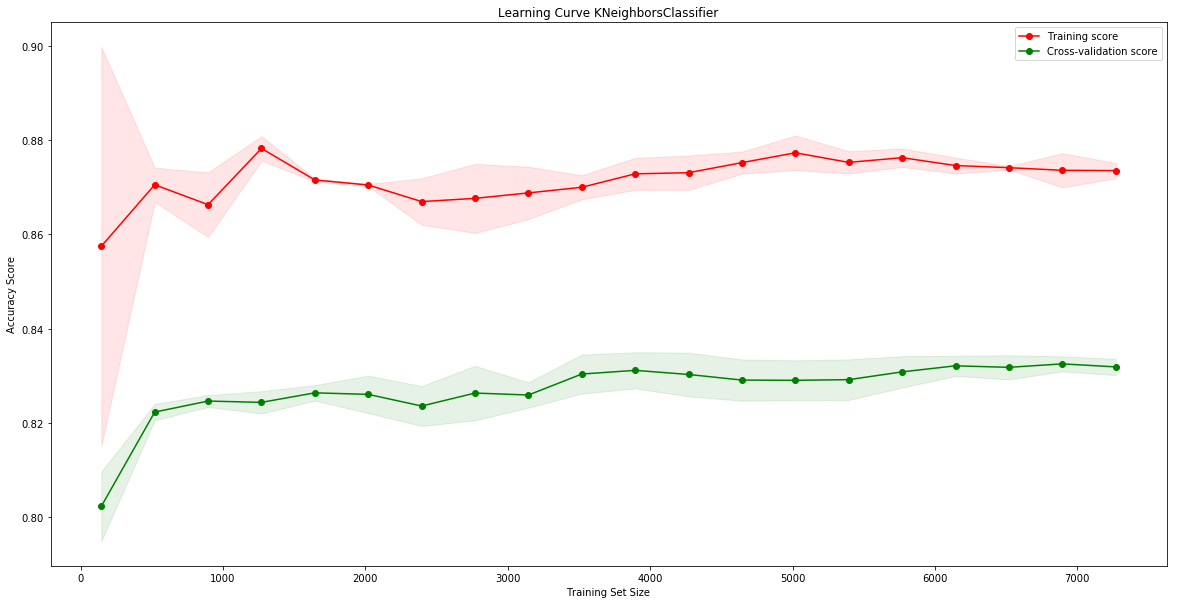

In [14]:
train_sizes, train_scores, test_scores = callLearningCurve(KNeighborsClassifier(n_neighbors=3), 
                                                           X_train, Y_train)
plotLearningCurve('Learning Curve KNeighborsClassifiern', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(KNeighborsClassifier(n_neighbors=7), 
                                                           X_train, Y_train)
plotLearningCurve('Learning Curve KNeighborsClassifier', train_sizes, train_scores, test_scores)

The variance between the test and train data doesn't change after the specific point. It is low bias and high variance

## c) Decision tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

for i in [4, 5, 6]:
    dt_classifier = DecisionTreeClassifier(max_depth=i)
    dt_classifier.fit(X_train, Y_train)
    Y_dt_pred = dt_classifier.predict(X_test)
    Y_dt_pred_proba = dt_classifier.predict_proba(X_test)
    print("Decision tree with max_dept ", i)
    print(classification_report(Y_test, Y_dt_pred))


Decision tree with max_dept  4
             precision    recall  f1-score   support

          0       0.86      0.95      0.90      8138
          1       0.76      0.52      0.62      2608

avg / total       0.84      0.84      0.83     10746

Decision tree with max_dept  5
             precision    recall  f1-score   support

          0       0.86      0.96      0.90      8138
          1       0.79      0.51      0.62      2608

avg / total       0.84      0.85      0.83     10746

Decision tree with max_dept  6
             precision    recall  f1-score   support

          0       0.87      0.95      0.91      8138
          1       0.79      0.54      0.64      2608

avg / total       0.85      0.85      0.84     10746



### Validation Curve

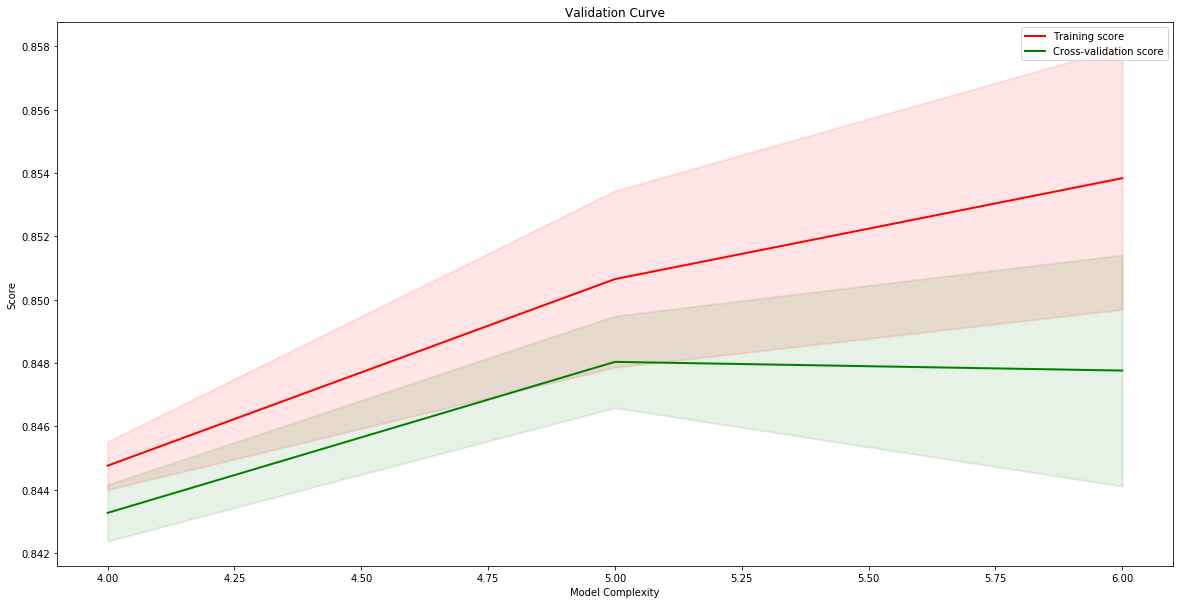

In [16]:
train_scores, test_scores = callValidationCurve(DecisionTreeClassifier(), X_train, Y_train, "max_depth", [4, 5, 6])
plotValidationCurve([4, 5, 6], train_scores, test_scores)

Observation:

The accuracy of the test does not change after than 5 value, and then the variance becomes larger then. 

### Learning curve

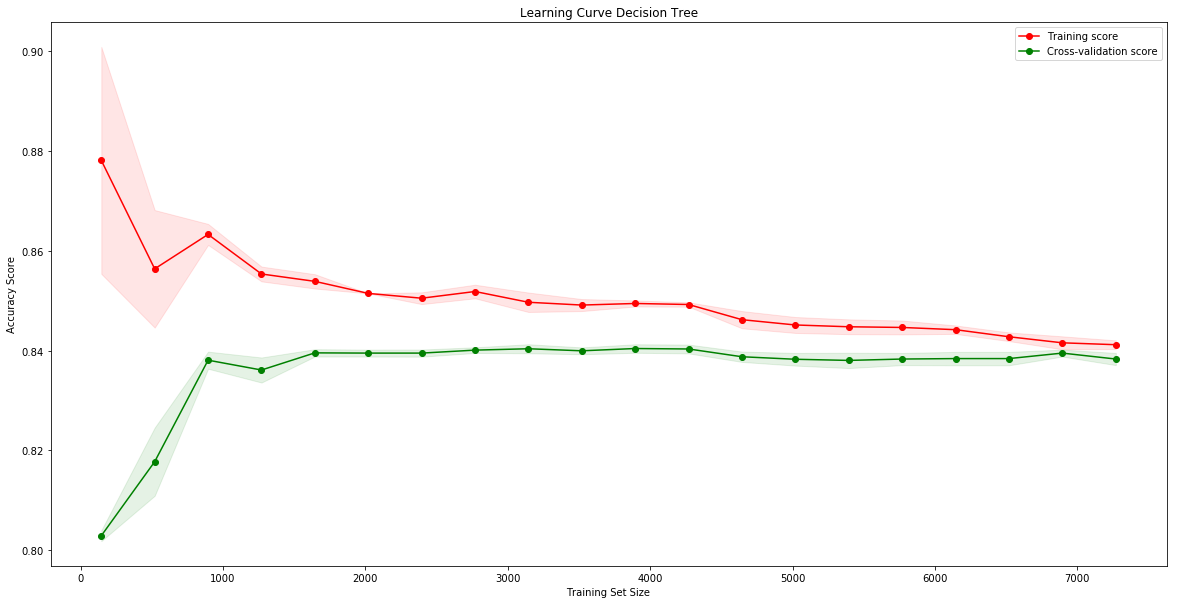

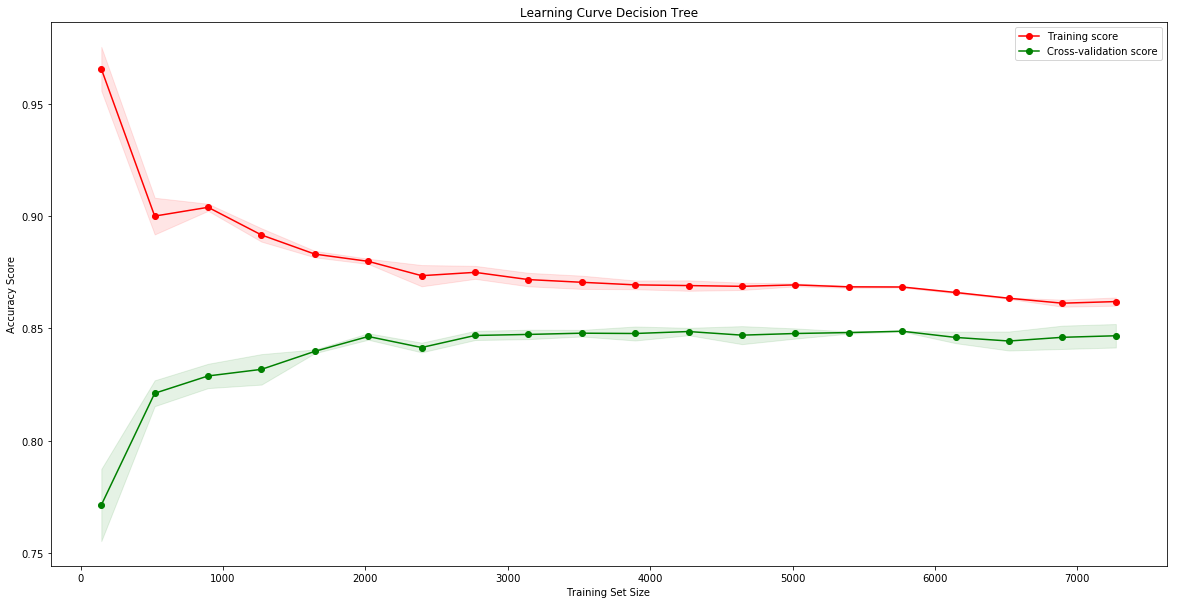

In [17]:
train_sizes, train_scores, test_scores = callLearningCurve(DecisionTreeClassifier(max_depth=3), X_train, Y_train)
plotLearningCurve('Learning Curve Decision Tree', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(DecisionTreeClassifier(max_depth=6), X_train, Y_train)
plotLearningCurve('Learning Curve Decision Tree', train_sizes, train_scores, test_scores)

First graph: The variance between the training data and the test data is not much, and later (when the sample is large enough) the accuracy of the algorithm is not improved much

Second graph: With the smaller dataset then the training data has high bias, and high variance. The error rate is high (or accuracy rate is low). The more data causes increases the accuracy of the test data and make the variance low.

## d) Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

?RandomForestClassifier

estimators = [30, 60, 90]
for n_estimators in estimators:
    rd_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=7)
    rd_classifier.fit(X_train, Y_train)
    Y_rf_pred = rd_classifier.predict(X_test)
    Y_rf_pred_proba = rd_classifier.predict_proba(X_test)
    print(classification_report(Y_test, Y_rf_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


             precision    recall  f1-score   support

          0       0.86      0.96      0.91      8138
          1       0.81      0.53      0.64      2608

avg / total       0.85      0.86      0.84     10746

             precision    recall  f1-score   support

          0       0.86      0.96      0.91      8138
          1       0.82      0.53      0.64      2608

avg / total       0.85      0.86      0.84     10746

             precision    recall  f1-score   support

          0       0.87      0.96      0.91      8138
          1       0.81      0.53      0.64      2608

avg / total       0.85      0.86      0.85     10746



### Validation Curve

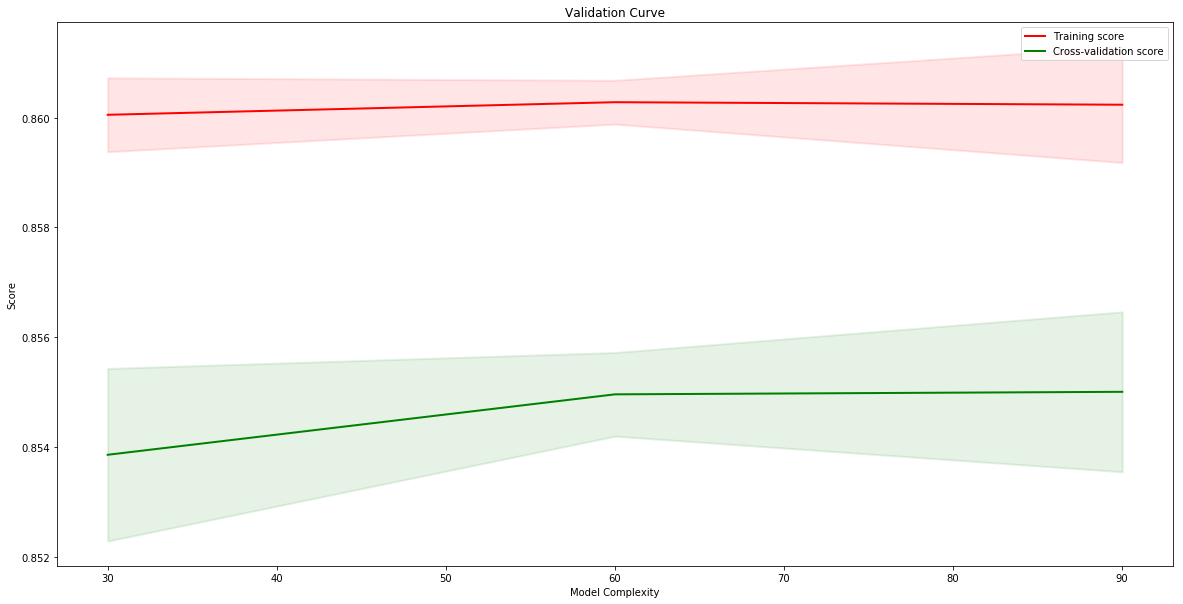

In [19]:
train_scores, test_scores = callValidationCurve(RandomForestClassifier(max_depth=7), X_train, Y_train,
                                                "n_estimators", estimators)
plotValidationCurve(estimators, train_scores, test_scores)

### Learning curve

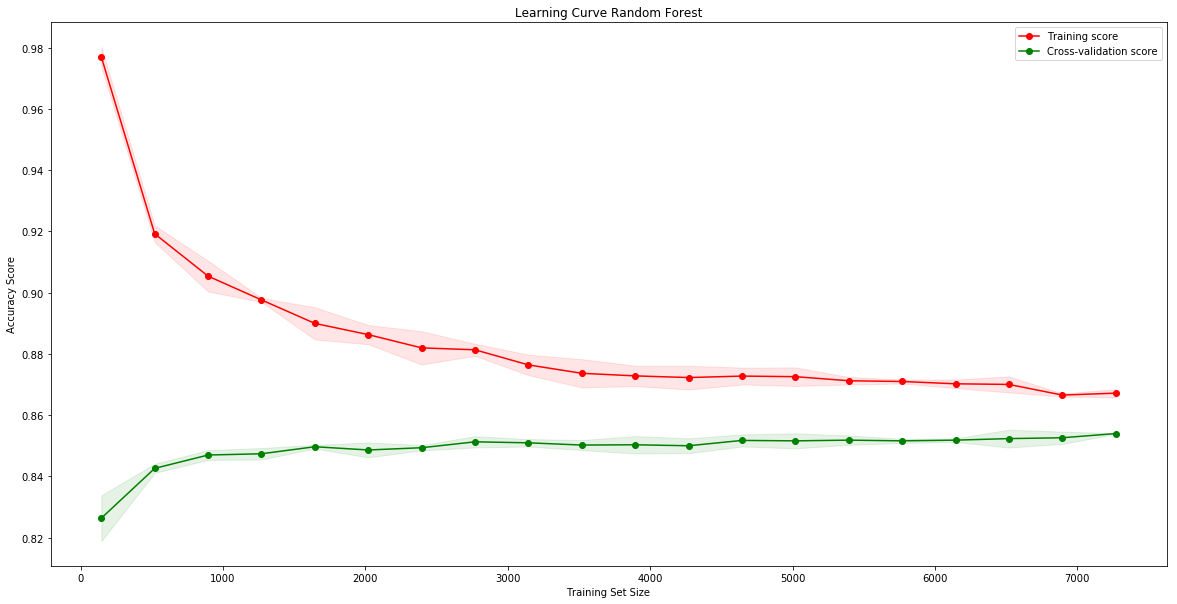

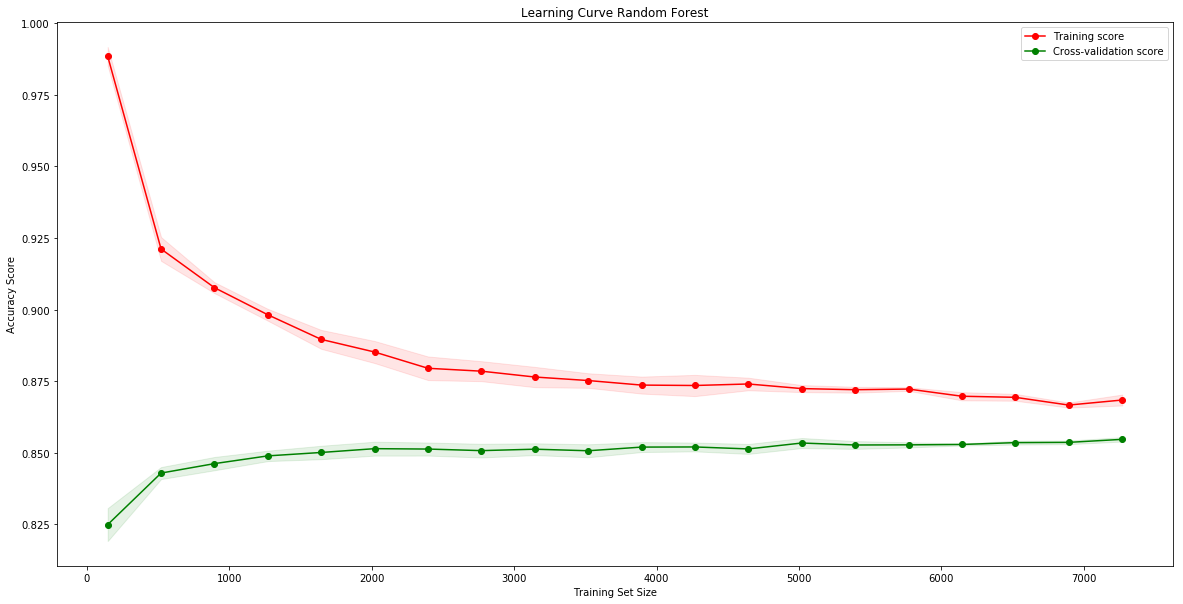

In [20]:
train_sizes, train_scores, test_scores = callLearningCurve(RandomForestClassifier(n_estimators=30, max_depth=7), X_train, Y_train)
plotLearningCurve('Learning Curve Random Forest', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(RandomForestClassifier(n_estimators=90, max_depth=7), X_train, Y_train)
plotLearningCurve('Learning Curve Random Forest', train_sizes, train_scores, test_scores)

## e) AdaBoost

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

estimators = [3,5,7,9]
for n_estimators in estimators:
    ada_classifier = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=0.5)
    ada_classifier.fit(X_train, Y_train)
    Y_ada_pred = ada_classifier.predict(X_test)
    Y_ada_pred_proba = ada_classifier.predict_log_proba(X_test)
    print(metrics.accuracy_score(Y_test, Y_ada_pred))
    print(classification_report(Y_test, Y_ada_pred))

0.8140703517587939
             precision    recall  f1-score   support

          0       0.83      0.96      0.89      8138
          1       0.73      0.37      0.49      2608

avg / total       0.80      0.81      0.79     10746

0.8386376326074818
             precision    recall  f1-score   support

          0       0.85      0.96      0.90      8138
          1       0.78      0.47      0.58      2608

avg / total       0.83      0.84      0.82     10746

0.8372417643774428
             precision    recall  f1-score   support

          0       0.85      0.96      0.90      8138
          1       0.78      0.46      0.58      2608

avg / total       0.83      0.84      0.82     10746

0.8430113530616044
             precision    recall  f1-score   support

          0       0.85      0.96      0.90      8138
          1       0.78      0.49      0.60      2608

avg / total       0.84      0.84      0.83     10746



Read the classification report, we see the best hyper-parameter for Adaboost classifier is 'n_estimators = 9' and the worst is 'n_estimators = 3'

### Validation Curve

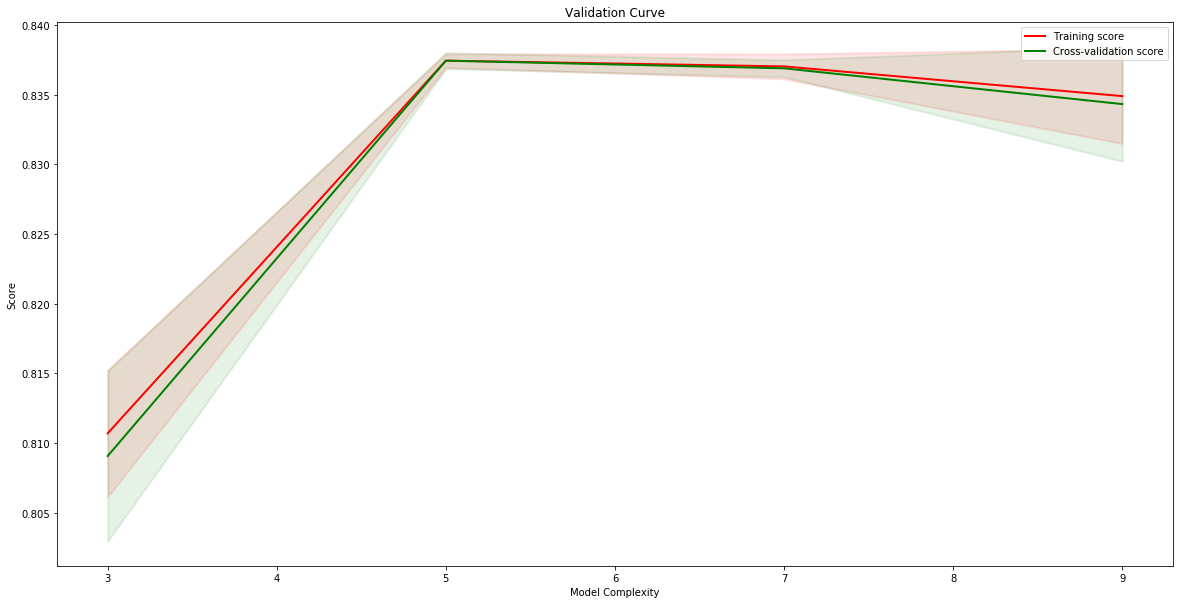

In [22]:
train_scores, test_scores = callValidationCurve(AdaBoostClassifier(learning_rate=0.5), X_train, Y_train,
                                                "n_estimators", estimators)
plotValidationCurve(estimators, train_scores, test_scores)

### Learning curve

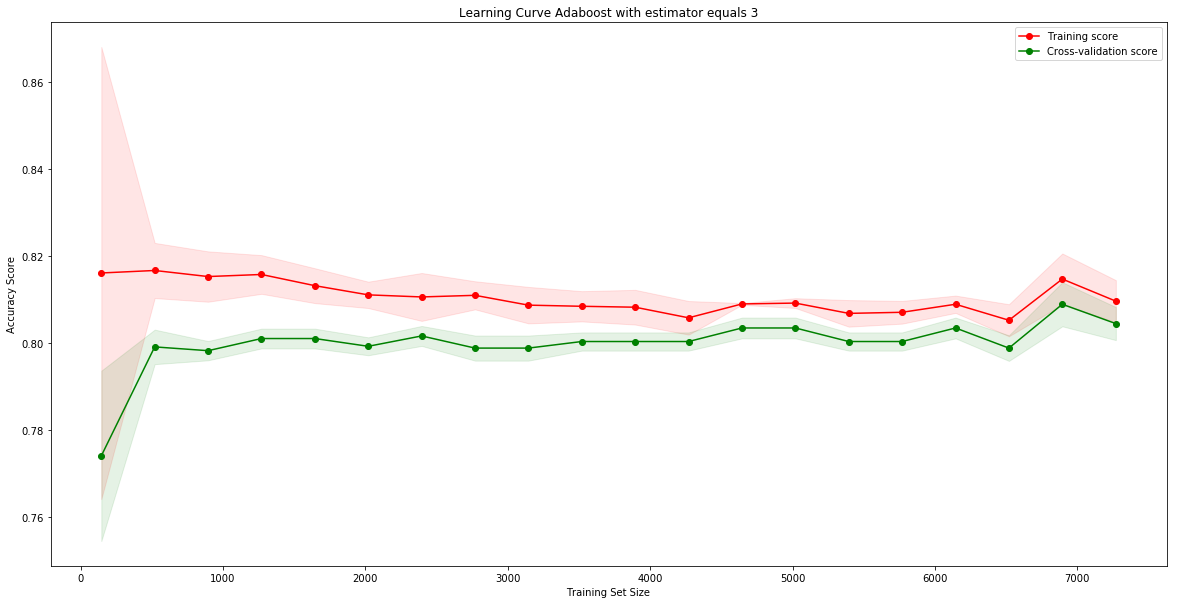

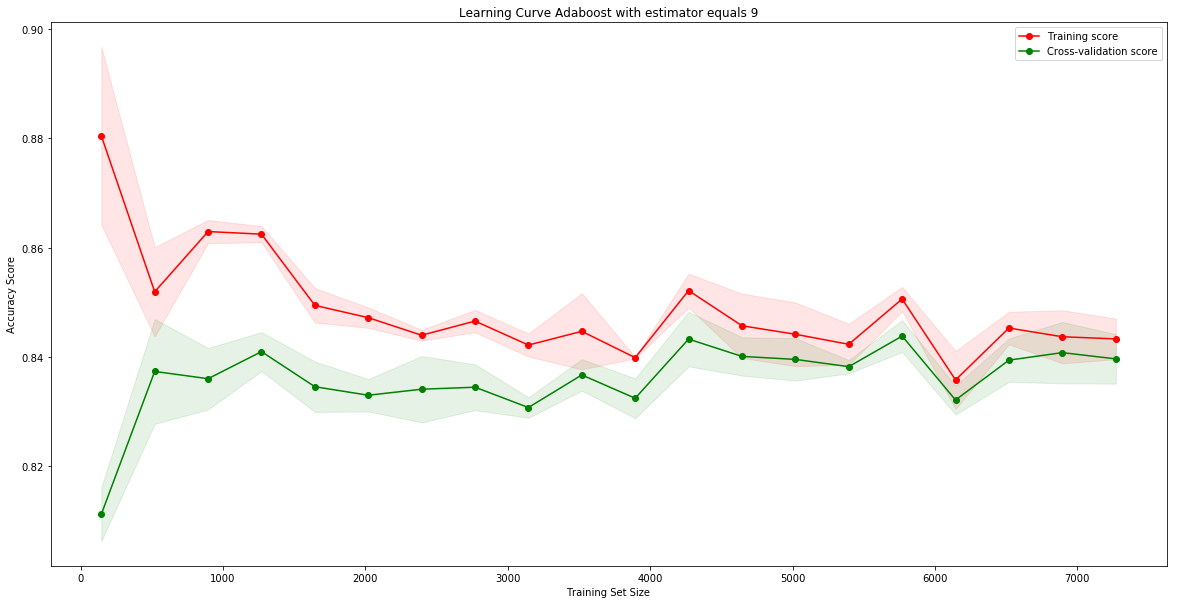

In [23]:
train_sizes, train_scores, test_scores = callLearningCurve(AdaBoostClassifier(n_estimators=3, 
                                                                              learning_rate=0.5), X_train, Y_train)
plotLearningCurve('Learning Curve Adaboost with estimator equals 3', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(AdaBoostClassifier(n_estimators=9, 
                                                                              learning_rate=0.5), X_train, Y_train)
plotLearningCurve('Learning Curve Adaboost with estimator equals 9', train_sizes, train_scores, test_scores)

## f) Neural Network 

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

iterators = [100, 300, 500]

for max_iter in iterators:
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=max_iter)
    mlp_classifier.fit(X_train, Y_train)
    Y_nn_pred = mlp_classifier.predict(X_test)
    Y_nn_pred_proba = mlp_classifier.predict_proba(X_test)
    print(metrics.accuracy_score(Y_test, Y_nn_pred))
    print(classification_report(Y_test, Y_nn_pred))

0.8519449097338545
             precision    recall  f1-score   support

          0       0.87      0.94      0.91      8138
          1       0.76      0.57      0.65      2608

avg / total       0.85      0.85      0.84     10746

0.8484087102177554
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      8138
          1       0.73      0.59      0.65      2608

avg / total       0.84      0.85      0.84     10746

0.8508282151498232
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      8138
          1       0.72      0.62      0.67      2608

avg / total       0.85      0.85      0.85     10746



Read the classification report, the best value for nueral network is max_iter = 500

### Validation Curve

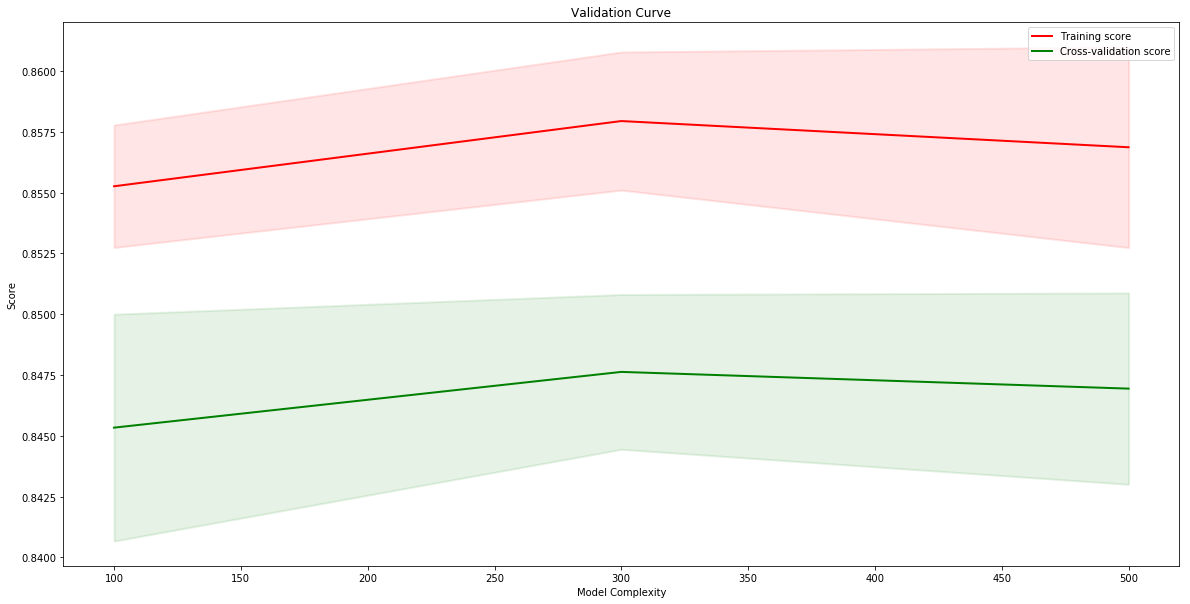

In [25]:
train_scores, test_scores = callValidationCurve(MLPClassifier(hidden_layer_sizes=(13,13,13)), X_train, Y_train,
                                                "max_iter", iterators)
plotValidationCurve(iterators, train_scores, test_scores)

### Learning Curve

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

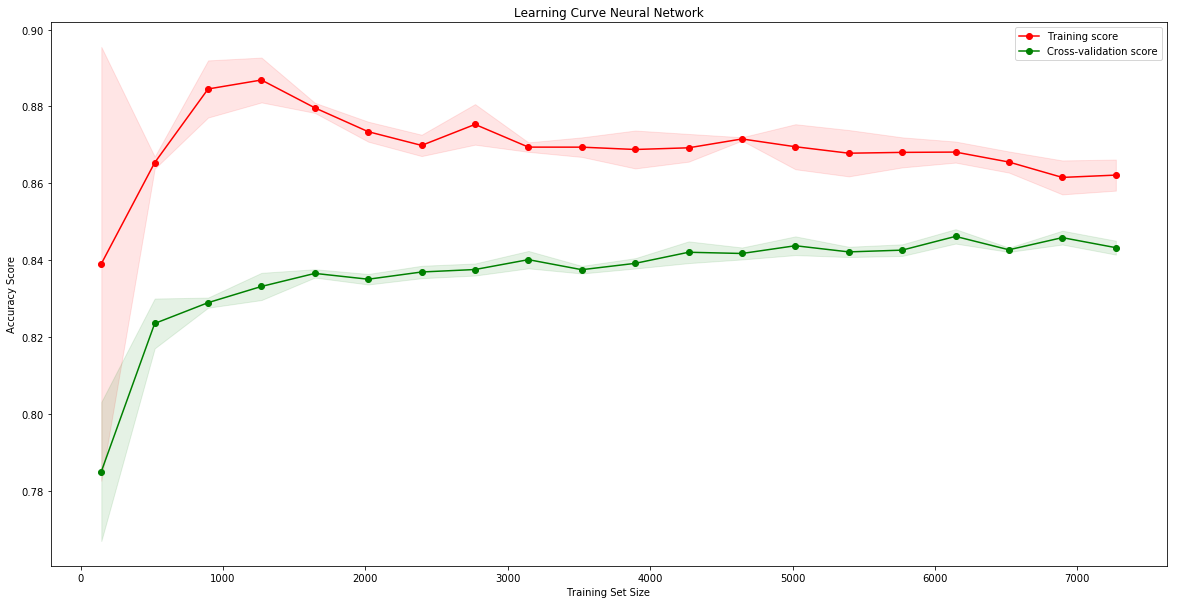

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

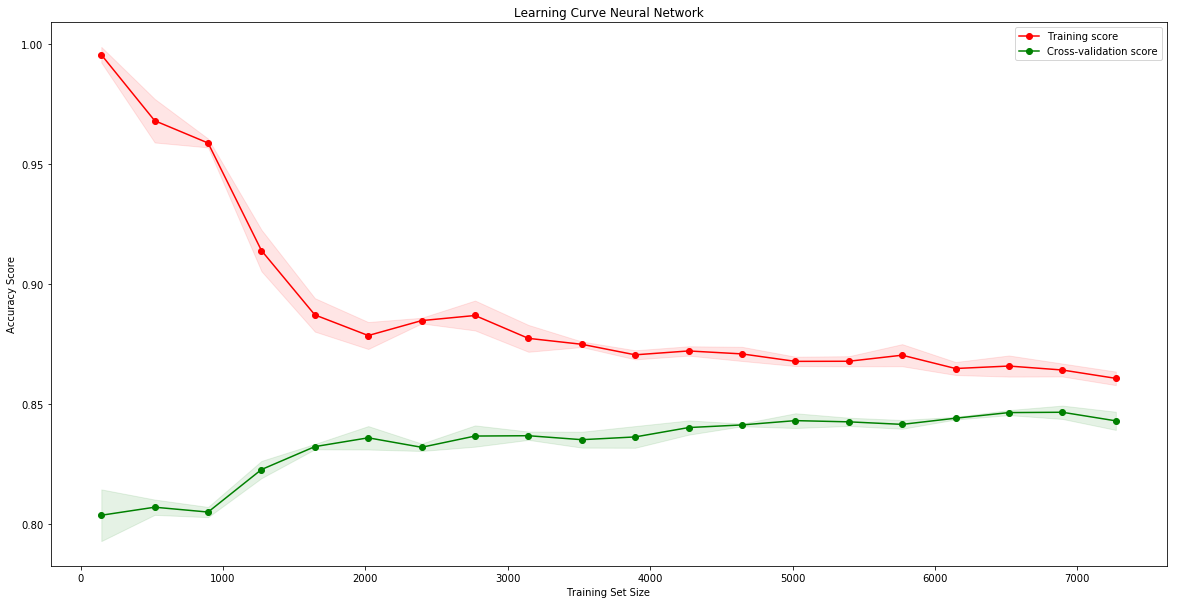

In [26]:
train_sizes, train_scores, test_scores = callLearningCurve(MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=100), X_train, Y_train)
plotLearningCurve('Learning Curve Neural Network', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500), X_train, Y_train)
plotLearningCurve('Learning Curve Neural Network', train_sizes, train_scores, test_scores)

# VI. AUC

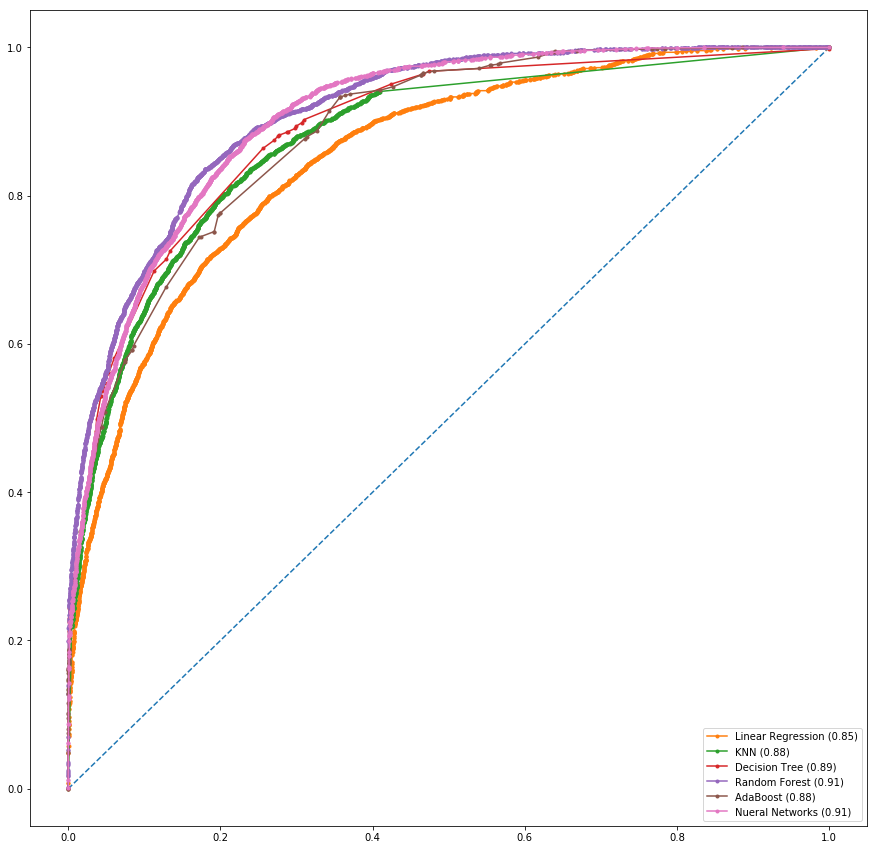

In [27]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

f,ax = plt.subplots(figsize=(15,15))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
preds = {"Linear Regression": Y_lg_pred_proba[:, 1], 
         "KNN": Y_knn_pred_proba[:, 1], 
         "Decision Tree": Y_dt_pred_proba[:, 1], 
         "Random Forest": Y_rf_pred_proba[:, 1], 
         "AdaBoost": Y_ada_pred_proba[:, 1], 
         "Nueral Networks": Y_nn_pred_proba[:, 1]}
for algorithm, pred in preds.items():
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test, pred)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', label = "{} ({:.2f})".format(algorithm, roc_auc_score(Y_test, pred)))

plt.legend(loc="lower right")
# show the plot
plt.show()

In [28]:
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, Y_train)
Y_tpot_pred = pipeline_optimizer.predict(X_test)

Generation 1 - Current best internal CV score: 0.8625708943150185
Generation 2 - Current best internal CV score: 0.8625708943150185
Generation 3 - Current best internal CV score: 0.8625708943150185
Generation 4 - Current best internal CV score: 0.8640838566451079
Generation 5 - Current best internal CV score: 0.8640838566451079

Best pipeline: RandomForestClassifier(ZeroCount(GaussianNB(input_matrix)), bootstrap=True, criterion=entropy, max_features=0.4, min_samples_leaf=12, min_samples_split=3, n_estimators=100)


In [29]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(metrics.accuracy_score(Y_test, Y_tpot_pred))
print(classification_report(Y_test, Y_tpot_pred))

0.8675786339102922
             precision    recall  f1-score   support

          0       0.89      0.95      0.92      8138
          1       0.79      0.62      0.69      2608

avg / total       0.86      0.87      0.86     10746



Observation: the generated model is better than our best model (N

# VII. References

1. [Plot validation curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html)

2. [Learning curve machine learning](https://www.dataquest.io/blog/learning-curves-machine-learning/)

3. [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

4. [TPOT](https://epistasislab.github.io/tpot/using)

5. [Machine Learning: Learning Curve](https://www.ritchieng.com/machinelearning-learning-curve/)